# Spam Text Message Classification using NLP

## Let's Get Started 

In [124]:
# import important modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS
np.random.seed(123)

In [125]:
# load data
data = pd.read_csv('spam.tsv', sep='\t')

In [126]:
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [127]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [128]:
# check the shape 
data.shape

(5572, 4)

In [129]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

we have more normal sms than spam sms 

## Data Exploratory

In [130]:
# explore ham labeled sms
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


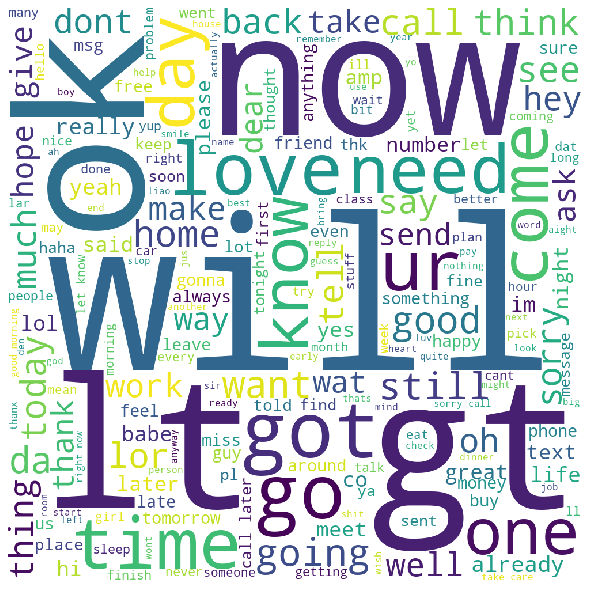

In [152]:
#visualize ham labeled sms
stopwords = set(STOPWORDS)
ham_words = collect_words(data,label='ham')

print("Total words {}".format(len(ham_words)))
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(ham_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Total words 104304


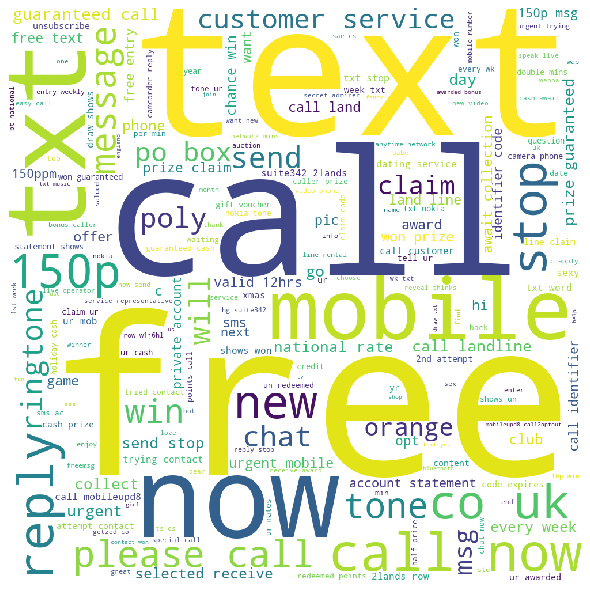

In [151]:
#visualize spam labeled sms
stopwords = set(STOPWORDS)
spam_words = collect_words(data,label='spam')
  
print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(spam_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Data Preparation 

In [133]:
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    data["message"],
    data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

### Pipeline and RF 

In [135]:
clf_rf = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words=stopwords,ngram_range=(1,2))),
        ("clf", RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    ]
)

In [136]:
clf_rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'also...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
               

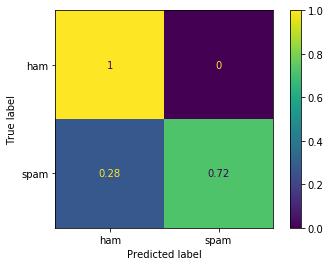

In [137]:
#plot the comfusion matrix 
plot_confusion_matrix(clf_rf,X_test,y_test,normalize='true')

In [138]:
y_pred = clf_rf.predict(X_test)

In [139]:
# check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       724
        spam       1.00      0.72      0.84       112

    accuracy                           0.96       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.96      0.96      0.96       836



In [140]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9629186602870813

In [141]:
clf_rf.predict(["Hey, how are you?"])

array(['ham'], dtype=object)

In [142]:
clf_rf.predict(["you have won free tickets to the Tanzania this summer."])

array(['ham'], dtype=object)

### SVM

In [143]:
clf_svm = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1))),
        ("clf", SVC(C=1000, gamma="auto")),
    ]
)

In [144]:
clf_svm.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'also...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1000, break_ties

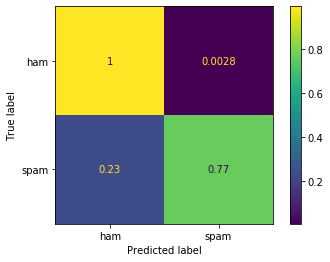

In [145]:
#plot the comfusion matrix
plot_confusion_matrix(clf_svm,X_test,y_test,normalize='true')

In [146]:
y_pred = clf_svm.predict(X_test)

In [147]:
# show the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       724
        spam       0.98      0.77      0.86       112

    accuracy                           0.97       836
   macro avg       0.97      0.88      0.92       836
weighted avg       0.97      0.97      0.96       836



In [148]:
accuracy_score(y_test, y_pred)

0.9665071770334929

In [149]:
clf_svm.predict(["Hey, how are you"])

array(['ham'], dtype=object)

In [150]:
clf_svm.predict(["you have got free tickets to the Tanzania this summer."])

array(['ham'], dtype=object)